# N/LAB Machine Learning and Advanced Analytics
## Practical 2

### Predicting Wine (modified problem, please use CSV URL). 
http://www.cs.nott.ac.uk/~pszgss/teaching/ML/Prac2/winequality-red.csv

**Input variables (based on physicochemical tests from samples from a glass): **
<br>fixed acidity 
<br>volatile acidity 
<br>citric acid 
<br>residual sugar 
<br>chlorides 
<br>free sulfur dioxide 
<br>total sulfur dioxide 
<br>density 
<br>pH 
<br>sulphates 
<br>alcohol 
<br>**Output variable (based on sensory data): **
<br>quality (score between 0 and 10)

**Problem:** Predict the wine quality score

# Task 1
Implement and compare both a mean learner and a kNN regressor.
<br>Test via cross validation.

<br>**HINT 1:** There are missing values. Decide how you will deal with this and implement your solution.
<br>**HINT 2:** If you would like to use kNN imputation then use the package [missingpy](https://pypi.org/project/missingpy/) as it implements the sklearn interface (unlike fancyimpute).

In [2]:
import pandas
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, KFold

data = pandas.read_csv('http://www.cs.nott.ac.uk/~pszgss/teaching/ML/Prac2/winequality-red.csv')

In [3]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [4]:
data.isnull().sum(axis = 0)

fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar          14
chlorides                0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       0
sulphates                0
alcohol                  0
quality                  0
dtype: int64

<AxesSubplot:>

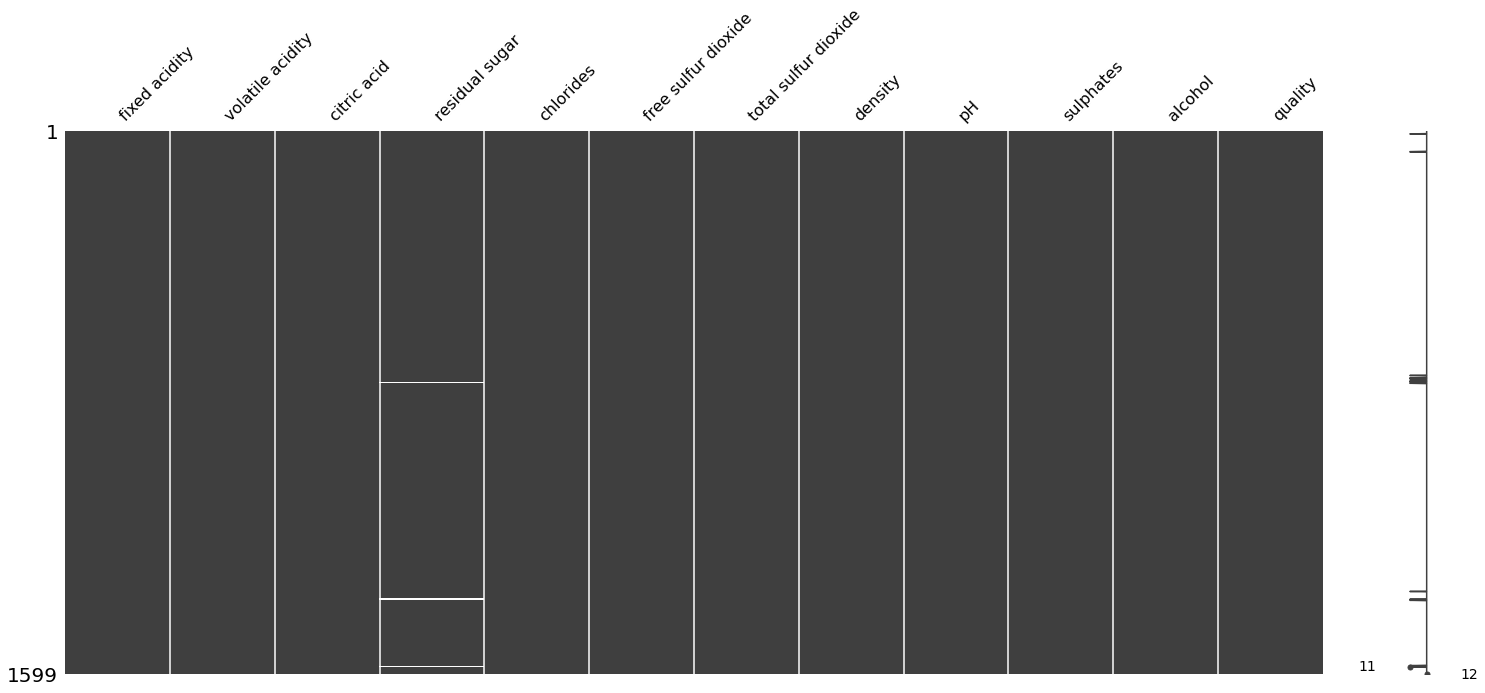

In [5]:
import missingno as msno
msno.matrix(data)

<AxesSubplot:>

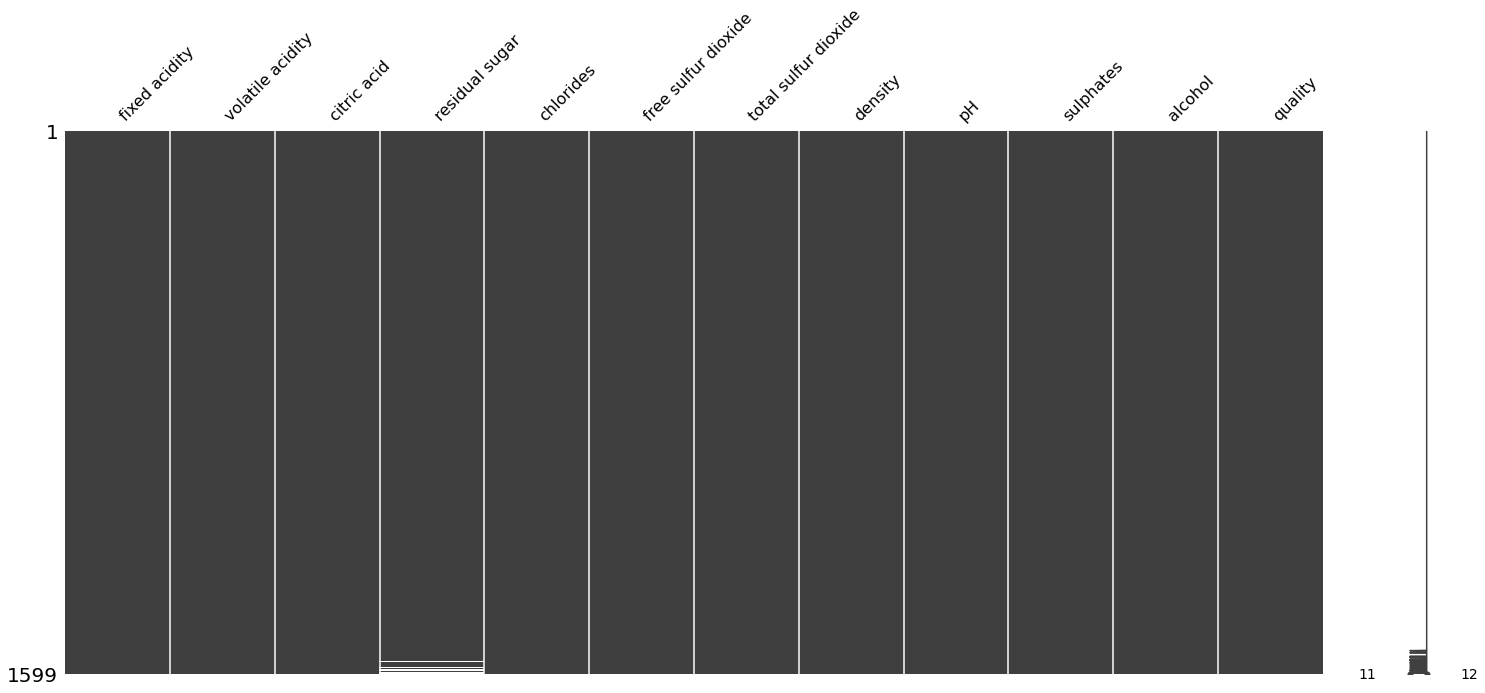

In [11]:
# Since measurements were taken from the glass missing values are more likely to be sensor errors or human error
# I.e. random. But is there a systmatic element?

# We could either directly go for some imputation method or investigate further
# to see if we could justify droping the data points assuming MCAR.

# One way would be to look at the points that would be deleted and see if they
# looked like random points. Another is to explicilty look to see if a simple
# relationship between the missing values and another variable exists.
# This can be done by sorting the values by each column one by one, plotting the graph
# and seeing where the missing values are.

msno.matrix(data.sort_values('density'))

In [7]:
# This implies MAR not MCAR, and so dropping instances is likely a bad idea as
# all wine with a high density will be discarded, effectively meaning our
# predictor will not be trained for this class of wine.

In [8]:
# So let's use the kNN imputer
# !pip install missingpy
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [22]:
y = data.quality
X = data.drop('quality',axis = 1) # 0 rows, 1 cols

imputer = KNNImputer(n_neighbors=3, weights="uniform")  ## the weights='uniform' or 'distance' 
## API: https://github.com/epsilon-machine/missingpy

In [26]:
pipe_dummy = Pipeline(steps=[('impute',imputer), ('predictor',DummyRegressor())])
pipe_knn = Pipeline(steps=[('impute',imputer), ('predictor',KNeighborsRegressor(n_neighbors = 1,p = 1))])

folds = KFold(n_splits=10, shuffle=True, random_state=0)

mae_dummy = -np.mean( cross_val_score(pipe_dummy, X, y, scoring = 'neg_mean_absolute_error', cv=folds) )
mae_knn = -np.mean( cross_val_score(pipe_knn, X, y, scoring = 'neg_mean_absolute_error', cv=folds) )


# NOTE: we can ignore the warnings here. For those who are interested:
# they are precision errors (i.e. zero is being represented as -0.000000000001)
# which means an error when you take the square root. In this does not cause any 
# issue to the algorithm. This is implementation specific and seems to occur
# most often in Python 3.6, at least on Linux.

In [27]:
print('dummy MAE: {}'.format(mae_dummy))
print('knn MAE: {}'.format(mae_knn))

dummy MAE: 0.6833925526743522
knn MAE: 0.48402908805031447


# Task 2
Did the regressor perform as well as you expected? Probably not. If you didn't already, consider the scales of all variables. Are they the same? No? Copy your solution, modifying it to include a pipeline which standarizes the inputs (standard scalar). Compare and contrast the results.

**NOTE:** If you already have included a standard scalar, compare your result to one without using it.

In [28]:
pipe_knn_standardized = Pipeline(steps=[('impute',imputer),('prep',StandardScaler()), ('predictor',KNeighborsRegressor(n_neighbors = 1,p = 1))])
mae_knn_standard = -np.mean( cross_val_score(pipe_knn_standardized, X, y, scoring = 'neg_mean_absolute_error', cv=folds) )

In [29]:
print('dummy MAE: {}'.format(mae_dummy))
print('knn MAE: {}'.format(mae_knn))
print('knn standardized MAE: {}'.format(mae_knn_standard))

dummy MAE: 0.6833925526743522
knn MAE: 0.48402908805031447
knn standardized MAE: 0.4152240566037736
